<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/Waypoint_FTDEMO_Mistral_7B_Instruct_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install colab-env -q
!pip install datasets -q
!pip install transformers -q
!pip install evaluate -q
!pip install bitsandbytes -q
!pip install accelerate -q

In [ ]:
from datasets import load_from_disk
import colab_env

#Prepare the Dataset
dataset = load_from_disk("/content/gdrive/MyDrive/datasets/flight_dataset_waypoints")
#print(dataset)  # Inspect the dataset

In [3]:
from datasets import load_from_disk

dataset = load_from_disk("/content/gdrive/MyDrive/datasets/flight_dataset_waypoints")


# Replace with your HF username and desired dataset name
dataset.push_to_hub("frankmorales2020/flight_plan_waypoints")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/frankmorales2020/flight_plan_waypoints/commit/875cf3439cd79ffd1d9c2f02e833104c565619d5', commit_message='Upload dataset', commit_description='', oid='875cf3439cd79ffd1d9c2f02e833104c565619d5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/frankmorales2020/flight_plan_waypoints', endpoint='https://huggingface.co', repo_type='dataset', repo_id='frankmorales2020/flight_plan_waypoints'), pr_revision=None, pr_num=None)

In [4]:
dataset

Dataset({
    features: ['input', 'label', 'distance', 'distance_category', 'waypoints', 'waypoint_names'],
    num_rows: 2000
})

In [10]:
dataset[999]

{'input': 'Calculate the waypoints from DEL to MSP. Departure: 2024-12-16, Aircraft: Boeing 757, Weather: Partly Cloudy',
 'label': 3,
 'distance': 1628.2675386906146,
 'distance_category': 'medium',
 'waypoints': [[38.6920451, -75.4013315],
  [41.13199069266402, -82.42994921256262],
  [42.51768770659504, -86.42165075117225],
  [42.123820505521195, -85.28705906429676],
  [44.878019050000006, -93.2209280537696]],
 'waypoint_names': ['DEL',
  'Prospect Road',
  'Michigan',
  'Q Drive South',
  'MSP']}

In [6]:
dataset[0]

{'input': 'Calculate the waypoints from SIN to CUN. Departure: 2024-06-19, Aircraft: Airbus A320, Weather: Partly Cloudy',
 'label': 7,
 'distance': 4190.223965150766,
 'distance_category': 'long',
 'waypoints': [[25.0000001, -107.5000001],
  [13.075850948259008, -87.47663616549106],
  [19.819922201759134, -98.80146877121005],
  [9.260386709076178, -81.06960216515675],
  [10.868386703521901, -83.76980061837503],
  [11.748790002704872, -85.24819840125659],
  [13.307169797892762, -87.86507323149776],
  [14.392416690114095, -89.68745009086217],
  [5.1096596, -74.0995854]],
 'waypoint_names': ['SIN',
  'Choluteca',
  'Santo Domingo Aztacameca',
  'Veraguas',
  'San Juan del Norte',
  'Acoyapa',
  'Pasaje La Cruz',
  'El Pito',
  'CUN']}

In [9]:
dataset[1999]

{'input': 'Calculate the waypoints from STL to BOG. Departure: 2024-09-06, Aircraft: Embraer E190, Weather: Clear',
 'label': 5,
 'distance': 4112.060597842354,
 'distance_category': 'long',
 'waypoints': [[38.74962725, -90.37047024952082],
  [21.18191627323041, -81.99991635501314],
  [10.923737947491404, -77.11216321240887],
  [15.739696160125035, -79.40684109194896],
  [25.474859626225587, -84.0453913602561],
  [13.045747925098976, -78.12324535656158],
  [4.7020946, -74.14771320401294]],
 'waypoint_names': ['STL',
  'Waypoint',
  'Waypoint',
  'Waypoint',
  'Waypoint',
  'Waypoint',
  'BOG']}

In [ ]:
!pip install colab-env -q
!pip install datasets -q
!pip install transformers -q
!pip install evaluate -q
!pip install bitsandbytes -q
!pip install accelerate -q

from datasets import load_from_disk
from datasets import Dataset
import torch
import colab_env


dataset = Dataset.load_from_disk("/content/gdrive/MyDrive/datasets/flight_dataset_waypoints")

from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, BitsAndBytesConfig
import torch
import bitsandbytes as bnb
import evaluate
from peft import LoraConfig, get_peft_model
import warnings
warnings.filterwarnings("ignore")

# Model and Tokenizer
#model_name = "mistralai/Mistral-7B-v0.1"
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Quantization Config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

# PEFT Configuration (LoRA)
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# Tokenize and Format
def tokenize_function(examples):
    # Directly use waypoint numbers as labels
    examples["labels"] = examples["label"]
    tokenized_output = tokenizer(
        examples["input"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    # Instead of assigning labels directly, shift them for causal LM
    tokenized_output['labels'] = tokenized_output['input_ids'].copy()
    # Replace input_ids corresponding to pad_token with -100 in labels
    tokenized_output['labels'] = [
        [-100 if token == tokenizer.pad_token_id else token for token in label_list]
        for label_list in tokenized_output['labels']
    ]
    return tokenized_output

tokenized_datasets = dataset.map(tokenize_function, batched=True)
print('\n')
print(tokenized_datasets)
print('\n')

# Remove unnecessary columns
tokenized_datasets = tokenized_datasets.remove_columns(["input", "label"])
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Split Dataset
train_testvalid = tokenized_datasets.train_test_split(test_size=0.2, seed=42)
train_dataset = train_testvalid["train"]
testvalid_dataset = train_testvalid["test"]
test_valid = testvalid_dataset.train_test_split(test_size=0.5, seed=42)
eval_dataset = test_valid["test"]
test_dataset = test_valid["train"]

small_train_dataset = train_dataset.shuffle(seed=42).select(range(1600))
small_eval_dataset = eval_dataset.shuffle(seed=42).select(range(200))

# Metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits[:, :-1, :].argmax(-1)
    labels_cleaned = labels[:, 1:]
    labels_cleaned = labels_cleaned[labels_cleaned != -100]
    predictions_cleaned = predictions.flatten()[labels[:, 1:].flatten() != -100]
    return metric.compute(predictions=predictions_cleaned, references=labels_cleaned)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=False,
    report_to='none',
    logging_steps=10,
)

In [2]:
train_dataset

Dataset({
    features: ['distance', 'distance_category', 'waypoints', 'waypoint_names', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 1600
})

In [3]:
eval_dataset

Dataset({
    features: ['distance', 'distance_category', 'waypoints', 'waypoint_names', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 200
})

In [4]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy
10,2.451800,2.065171,0.551744
20,1.797600,1.506511,0.647919
30,1.271200,1.053995,0.724747
40,0.949700,0.851820,0.801575
50,0.825500,0.776427,0.808999
60,0.765900,0.744111,0.812261
70,0.734000,0.730188,0.816085
80,0.717700,0.720531,0.816648
90,0.708400,0.714244,0.814061
100,0.706200,0.714203,0.816085


TrainOutput(global_step=1000, training_loss=0.6381401214599609, metrics={'train_runtime': 8574.4269, 'train_samples_per_second': 0.933, 'train_steps_per_second': 0.117, 'total_flos': 4.3708833595392e+16, 'train_loss': 0.6381401214599609, 'epoch': 5.0})

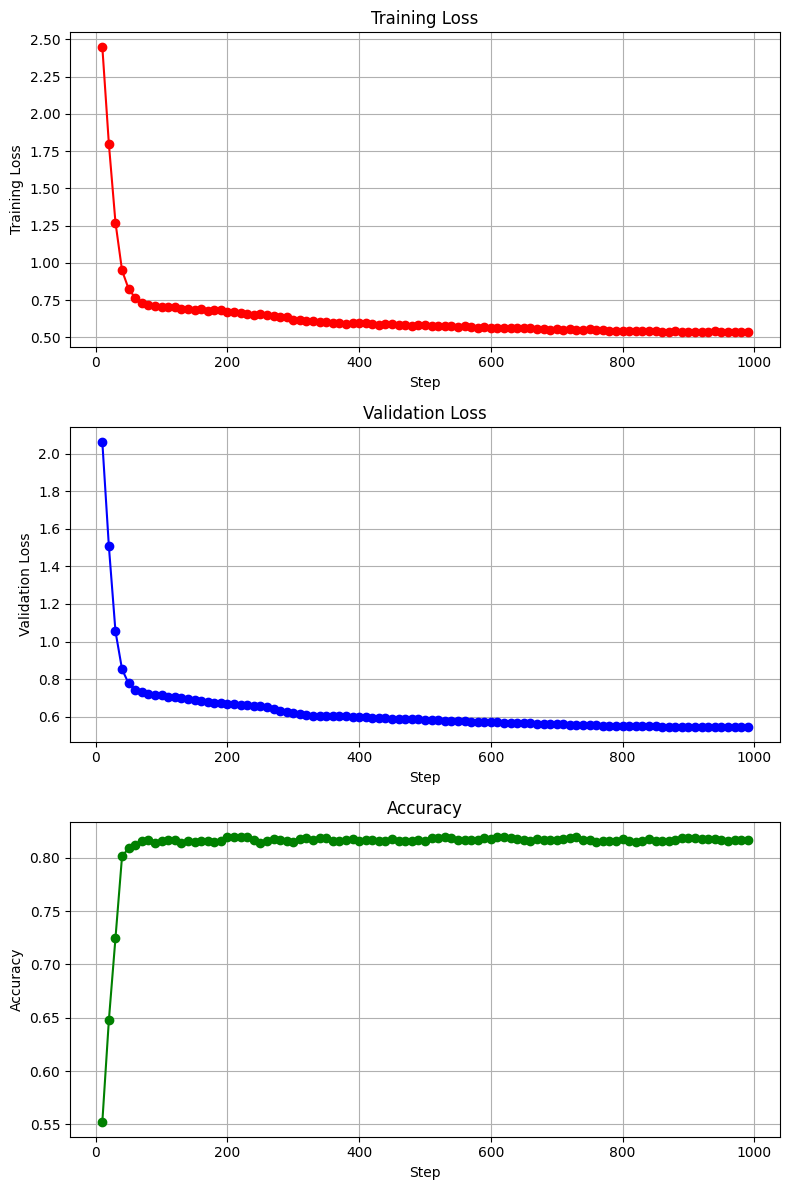

In [24]:
import matplotlib.pyplot as plt

steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530,540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000]  # Add more steps as needed
training_loss = [2.451800, 1.797600, 1.271200, 0.949700, 0.825500, 0.765900, 0.734000, 0.717700, 0.708400, 0.706200, 0.704100, 0.707800, 0.688800, 0.692000, 0.683800, 0.688400, 0.677500, 0.686200, 0.681200, 0.669300, 0.671600, 0.663200, 0.660900, 0.651600, 0.654500, 0.648100, 0.642300, 0.635900, 0.637000, 0.618400, 0.615000, 0.609000, 0.607700, 0.604400, 0.602800, 0.599200, 0.597700, 0.592400, 0.599500, 0.595900, 0.595300, 0.588900, 0.584000, 0.589300, 0.587200, 0.586300, 0.586100, 0.577300, 0.582100, 0.582100, 0.580100, 0.578900, 0.575700, 0.576000, 0.569000, 0.574900, 0.570300, 0.566300, 0.570500, 0.560800, 0.563100, 0.566200, 0.565200, 0.560800, 0.560800, 0.562300, 0.554800, 0.558100, 0.552200, 0.556800, 0.552200, 0.557600, 0.551200, 0.551800, 0.556300, 0.549400, 0.548500, 0.545600, 0.544400, 0.540400, 0.545700, 0.540600, 0.540200, 0.540300, 0.543600, 0.536100, 0.539200, 0.541200, 0.535200, 0.538100, 0.539700, 0.536900, 0.539500, 0.543600, 0.535000, 0.539200, 0.537300, 0.539800, 0.533900] # Add more values as needed
validation_loss = [2.065171, 1.506511, 1.053995, 0.851820, 0.776427, 0.744111, 0.730188, 0.720531, 0.714244, 0.714203, 0.706570, 0.701782, 0.697830, 0.691589, 0.689416, 0.682229, 0.679929, 0.674627, 0.672538, 0.668514, 0.665994, 0.663546, 0.660496, 0.656052, 0.655763, 0.650270, 0.640356, 0.631797, 0.626434, 0.620960, 0.611835, 0.607430, 0.605202, 0.603025, 0.601887, 0.603363, 0.602101, 0.601419, 0.599380, 0.597438, 0.595999, 0.593003, 0.593876, 0.590896, 0.588592, 0.588299, 0.586895, 0.585894, 0.585344, 0.583021, 0.581254, 0.580207, 0.578432, 0.578551, 0.577802, 0.574498, 0.573231, 0.572399, 0.569909, 0.569906, 0.568733, 0.568005, 0.566421, 0.564678, 0.564539, 0.563396, 0.561674, 0.560662, 0.560653, 0.559441, 0.558193, 0.556504, 0.555215, 0.554148, 0.553238, 0.553096, 0.551884, 0.551138, 0.550206, 0.549698, 0.549616, 0.549430, 0.548791, 0.548163, 0.547357, 0.546597, 0.546006, 0.545643, 0.545125, 0.544650, 0.544153, 0.543789, 0.543306, 0.542904, 0.542692, 0.542499, 0.542387, 0.542265, 0.542207]  # Add more values as needed
accuracy = [0.551744, 0.647919, 0.724747, 0.801575, 0.808999, 0.812261, 0.816085, 0.816648, 0.814061, 0.816085, 0.816423, 0.816535, 0.814286, 0.816085, 0.814736, 0.815861, 0.815636, 0.815298, 0.816198, 0.819123, 0.819798, 0.819573, 0.819348, 0.817210, 0.813611, 0.815973, 0.817323, 0.816535, 0.815973, 0.814623, 0.817885, 0.818673, 0.816873, 0.818335, 0.818448, 0.816085, 0.815861, 0.816423, 0.817435, 0.815748, 0.816310, 0.816873, 0.815636, 0.816085, 0.817323, 0.815748, 0.815861, 0.815411, 0.816423, 0.815861, 0.818560, 0.818335, 0.819573, 0.818785, 0.816310, 0.816985, 0.816760, 0.816310, 0.818785, 0.817885, 0.819910, 0.819235, 0.818335, 0.817548, 0.816310, 0.815523, 0.817660, 0.816873, 0.817098, 0.816873, 0.817885, 0.818448, 0.819123, 0.816760, 0.816873, 0.815298, 0.815861, 0.815973, 0.815973, 0.818110, 0.816085, 0.814961, 0.816198, 0.817773, 0.816085, 0.815523, 0.815861, 0.816873, 0.819010, 0.818560, 0.818223, 0.817548, 0.817323, 0.817323, 0.816985, 0.816198, 0.816535, 0.816873, 0.816648] # Add more values as needed


# Ensure that 'steps' and 'training_loss' have the same length
min_length = min(len(steps), len(training_loss), len(validation_loss), len(accuracy))
steps = steps[:min_length]
training_loss = training_loss[:min_length]
validation_loss = validation_loss[:min_length]
accuracy = accuracy[:min_length]


# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot Training Loss
axs[0].plot(steps, training_loss, marker='o', color='red')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Training Loss')
axs[0].grid(True)

# Plot Validation Loss
axs[1].plot(steps, validation_loss, marker='o', color='blue')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Validation Loss')
axs[1].grid(True)

# Plot Accuracy
axs[2].plot(steps, accuracy, marker='o', color='green')
axs[2].set_title('Accuracy')
axs[2].set_xlabel('Step')
axs[2].set_ylabel('Accuracy')
axs[2].grid(True)

plt.tight_layout()
plt.show()